### DESEQ2 analysis of Hydrogel dataset

2 Factor design: 

* Stiffness (Soft v Stiff) 
* Saha (yes, no) 

* 221511 naive overlap peaks 
* 3 biological replicates per Sample 

## In this notebook we compare the soft samples treated with SAHA to the soft samples not treated with SAHA 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('hydrogel.soft.stiff.saha.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL

#data=data[rowSums(data)>0,]


In [3]:
head(data)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3,saha_2000Pa_Rep1,saha_2000Pa_Rep2,saha_2000Pa_Rep3
chr1_713708_714452,6,11,7,17,27,17,25,23,16,22,24,20
chr1_762643_763047,1,5,0,3,7,4,5,5,2,3,6,7
chr1_802987_803295,2,7,4,3,3,1,8,6,6,7,8,4
chr1_804984_805589,2,6,1,6,7,6,7,3,4,5,16,4
chr1_834765_835239,7,12,14,15,7,9,5,2,0,8,10,4
chr1_839144_839717,13,17,5,23,15,20,6,4,3,5,12,11


In [4]:
#load the metadata
batches=read.table("batches_hydrogel.soft.stiff.saha.txt",header=TRUE,sep='\t',row.names=1)
batches$Stiffness=factor(batches$Stiffness)
batches$Saha=factor(batches$Saha)
batches$Sample=factor(batches$Sample)


In [5]:
batches

,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa
saha_100Pa_Rep1,Soft,Yes,saha_100Pa
saha_100Pa_Rep2,Soft,Yes,saha_100Pa
saha_100Pa_Rep3,Soft,Yes,saha_100Pa
saha_2000Pa_Rep1,Stiff,Yes,saha_2000Pa


## Soft-no-SAHA vs Soft-with-SAHA


In [6]:
soft_stiff_data=data[,c(1,2,3,7,8,9)]
soft_stiff_batches=batches[c(1,2,3,7,8,9),]

In [7]:
head(soft_stiff_data)
soft_stiff_batches

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3
chr1_713708_714452,6,11,7,25,23,16
chr1_762643_763047,1,5,0,5,5,2
chr1_802987_803295,2,7,4,8,6,6
chr1_804984_805589,2,6,1,7,3,4
chr1_834765_835239,7,12,14,5,2,0
chr1_839144_839717,13,17,5,6,4,3


,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
saha_100Pa_Rep1,Soft,Yes,saha_100Pa
saha_100Pa_Rep2,Soft,Yes,saha_100Pa
saha_100Pa_Rep3,Soft,Yes,saha_100Pa


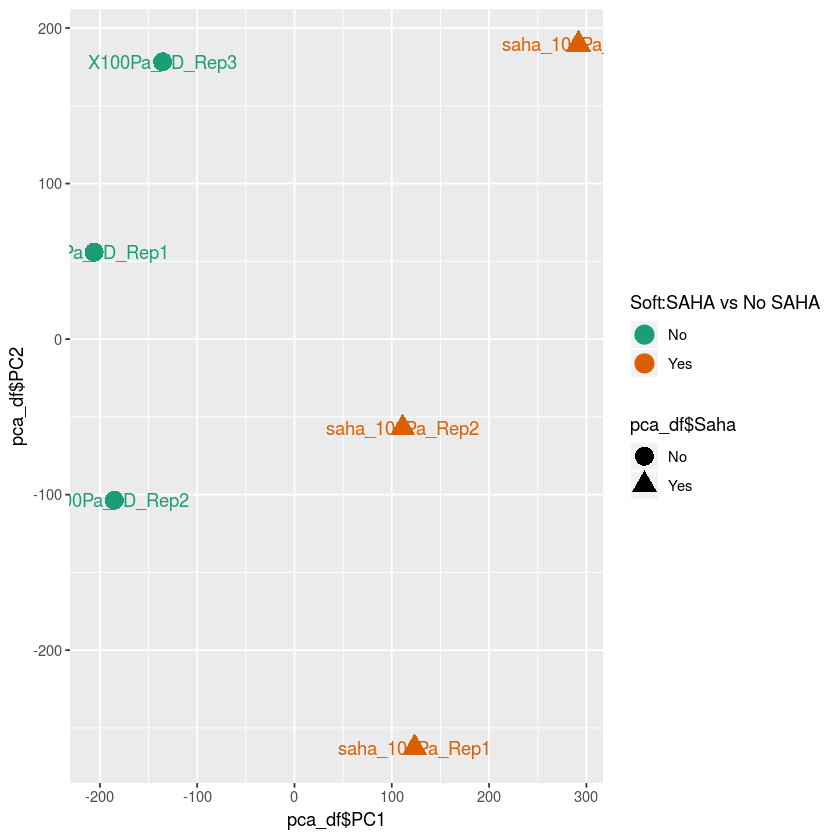

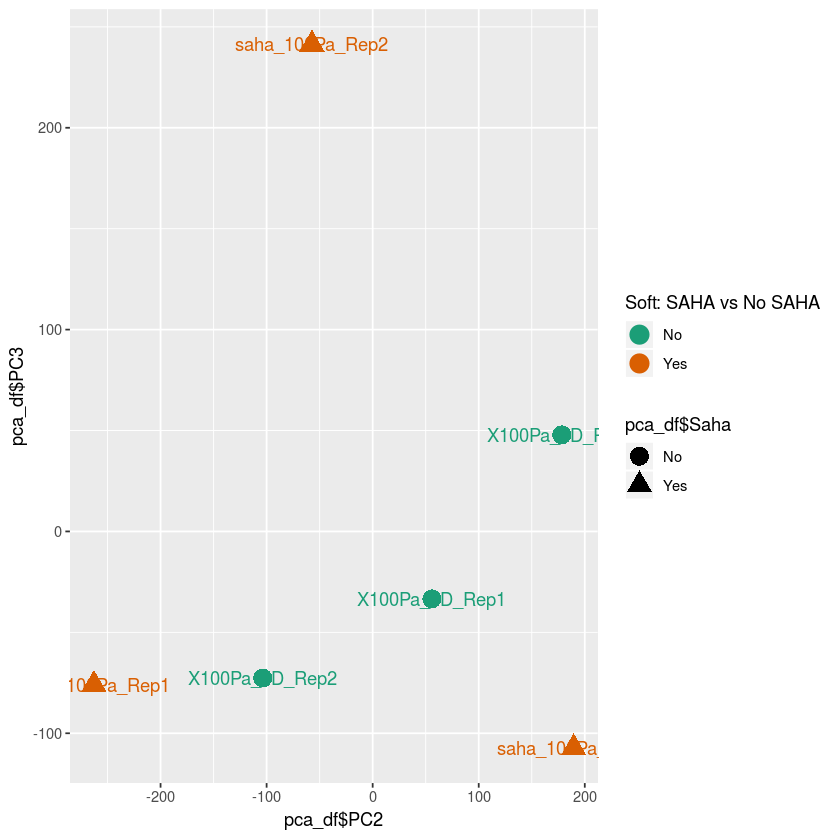

In [8]:
#PCA on shifted log of normalized counts
normcounts=soft_stiff_data
normcounts[normcounts<0]=0
lognc=log2(normcounts+1)
data.pca=prcomp(t(lognc))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)

pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            label=rownames(pca_df),
            color=pca_df$Saha,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft:SAHA vs No SAHA',values=c("#1b9e77","#d95f02"))
p1

p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            label=rownames(pca_df),
            color=pca_df$Saha,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft: SAHA vs No SAHA',values=c("#1b9e77","#d95f02"))
p2

In [9]:
var_explained_df


seq.1..length.var_explained..,var_explained
1,35.87
2,26.56
3,14.53
4,12.16
5,10.88
6,0.00


In [10]:
pc1_loadings=sort(data.pca$rotation[, 1])
upper_bound=mean(pc1_loadings)+2.5*sd(pc1_loadings)
toselect=c(names(pc1_loadings[pc1_loadings>upper_bound]))
heatmap_indices=match(toselect,rownames(lognc))
head(heatmap_indices)
forheatmap=lognc[heatmap_indices,]
outfname=paste("pc1.nosv.softsaha_vs_softnosaha.highest.",2.5,'.tsv',sep='')
write.table(forheatmap,file=outfname,row.names=TRUE,col.names=TRUE,sep='\t')

[1]  34210 156440 153927 217175 114444 215679

In [11]:
#Surrogate Variable Analysis 
soft_stiff_data=soft_stiff_data[rowSums(soft_stiff_data)>0,]
mod0=model.matrix(~1,data=soft_stiff_batches)
mod1=model.matrix(~Saha,data=soft_stiff_batches)
sva.obj=svaseq(as.matrix(soft_stiff_data),mod1,mod0)


Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

In [12]:
sur_var=data.frame(sva.obj$sv)
names(sur_var)=c("sv1")
soft_stiff_batches=cbind(soft_stiff_batches,sur_var)

In [13]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = soft_stiff_data,
                              colData = soft_stiff_batches,
                              design = ~Saha+sv1)


In [14]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("../../diff_peaks/background/hydrogel.soft.stiff.saha.HK.txt",header=FALSE,sep='\t')
hk_promoters=paste(hk_promoters[,1],hk_promoters[,2],hk_promoters[,3],sep="_")
soft_stiff_hk_promoter_indices=match(hk_promoters,rownames(soft_stiff_data))
head(soft_stiff_hk_promoter_indices)

[1] 15 63 70 71 71 78

In [15]:
dds <- estimateSizeFactors(dds, controlGenes=soft_stiff_hk_promoter_indices)

## Extract and store normalized counts for further analysis 

In [16]:
normcounts=counts(dds,normalized=TRUE)

#use limma's removeBatchEffect function 
tokeep=model.matrix(~Saha,data=soft_stiff_batches)
normcounts=removeBatchEffect(normcounts,design=tokeep,covariates = subset(soft_stiff_batches,select=c("sv1")))


write.table(normcounts,"soft_stiff_normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


In [17]:
head(normcounts)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3
chr1_713708_714452,8.644084,10.968123,10.329669,15.092771,17.466304,15.974453
chr1_762643_763047,1.014893,3.899152,0.336800,2.185027,3.582461,3.944460
chr1_802987_803295,3.040704,7.153528,5.817086,5.142049,4.643552,5.293530
chr1_804984_805589,2.689405,5.446201,1.600950,3.884467,2.210314,4.792490
chr1_834765_835239,10.012225,11.850858,20.915123,3.363964,1.621238,-1.090549
chr1_839144_839717,17.644529,14.951546,7.999361,2.507934,2.762182,5.657594


## Differential Accessibility Operation

In [18]:
#Run the differential analysis
dds <- DESeq(dds,parallel = TRUE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 20 workers


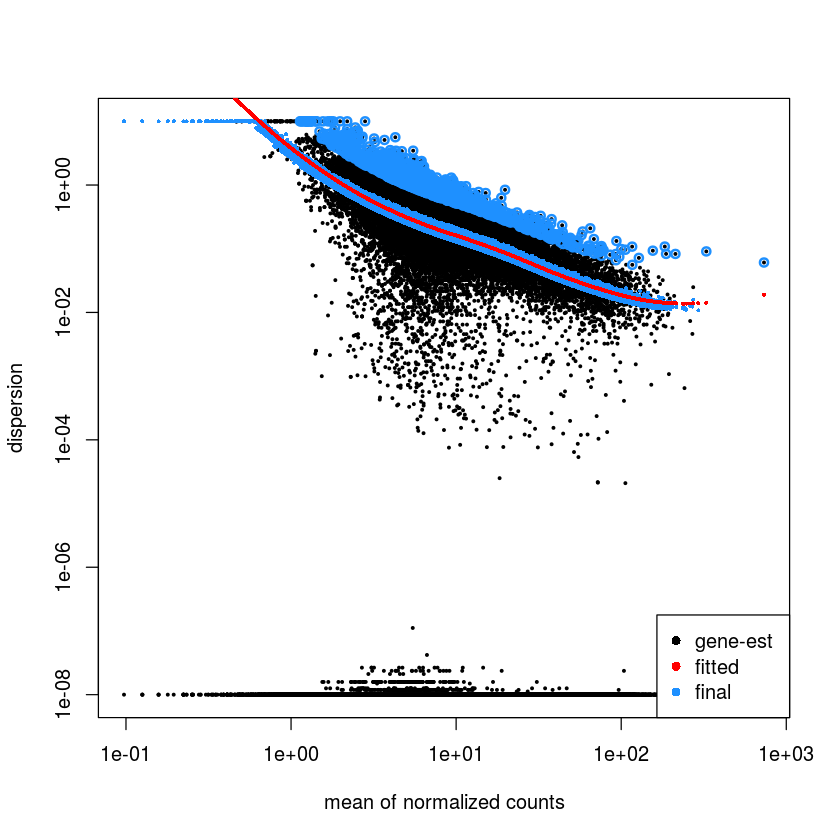

In [19]:
plotDispEsts(dds)

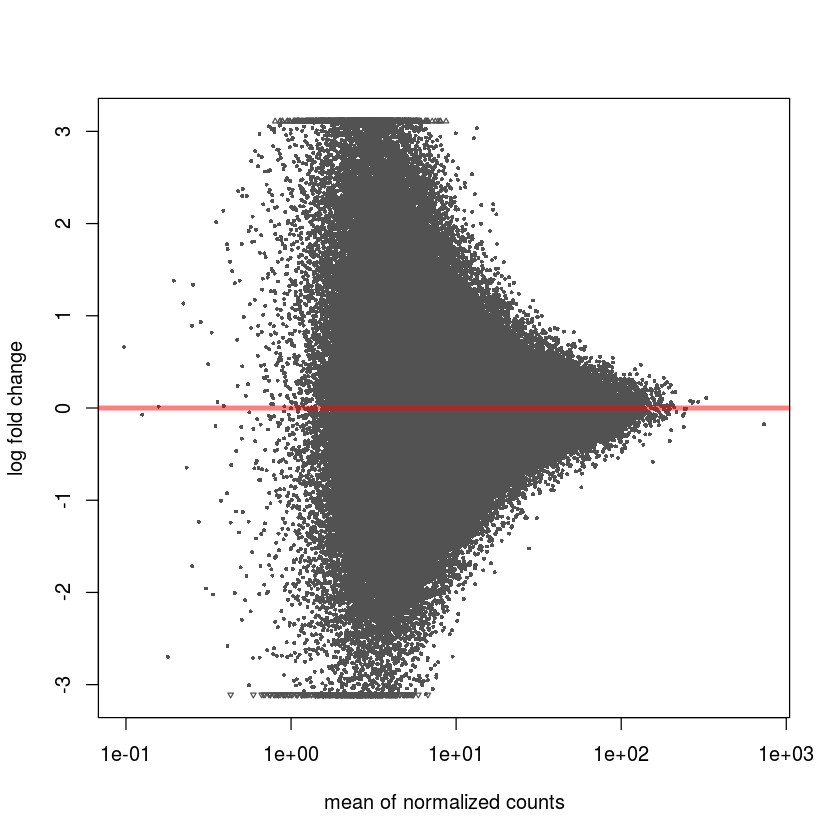

In [20]:
DESeq2::plotMA(dds)

## Standard BH Correction (no optimal thresholding) 

In [21]:
res=results(dds)
summary(res)

res=results(dds,independentFiltering=FALSE)
summary(res)

res=results(dds,filterFun = ihw)
summary(res)


out of 221479 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221479 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221479 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [22]:

resultsNames(dds)

[1] "Intercept"      "Saha_Yes_vs_No" "sv1"

In [23]:
res=results(dds,name="Saha_Yes_vs_No",parallel=TRUE)

[1] 807


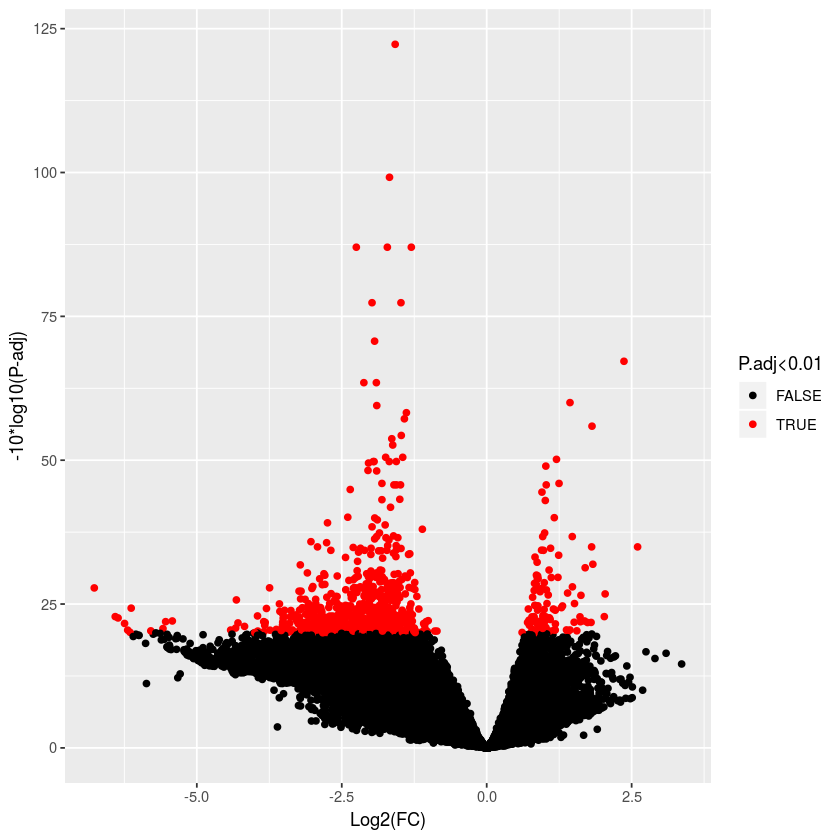

In [24]:
        res$logPadj=-10*log10(res$padj)
        res=as.data.frame(res)
        res=na.omit(res)
        numsig=sum(res$padj <= 0.01)
        sigsubset=res[res$padj<=0.01,]
        res$color=res$padj<=0.01
        ggplot(data=res,
        aes(x=res$log2FoldChange,
                 y=res$logPadj,
                 color=res$color))+
                 geom_point()+
                 xlab("Log2(FC)")+
                 ylab("-10*log10(P-adj)")+
                 scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.01")
print(numsig)

In [25]:
res[res$padj<=0.01,]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,logPadj,color
chr1_934438_937487,62.936398,-1.0439740,0.2429611,-4.296877,1.732210e-05,6.394171e-03,21.94216,TRUE
chr1_2783143_2783838,14.648786,-2.5679455,0.5933794,-4.327662,1.507007e-05,6.127209e-03,22.12737,TRUE
chr1_3633523_3634331,39.072175,1.5083531,0.3524998,4.279018,1.877194e-05,6.548825e-03,21.83837,TRUE
chr1_5671426_5672569,25.882298,-1.8594755,0.3965447,-4.689195,2.742819e-06,2.230358e-03,26.51625,TRUE
chr1_7797716_7798821,13.933830,-3.2021113,0.6743034,-4.748770,2.046580e-06,1.888667e-03,27.23845,TRUE
chr1_15092107_15092909,17.719844,-2.2595832,0.5087994,-4.441010,8.953774e-06,4.625237e-03,23.34866,TRUE
chr1_17050562_17051901,23.739097,-1.9282164,0.4256761,-4.529773,5.904701e-06,3.623321e-03,24.40893,TRUE
chr1_17895682_17896863,29.380825,-1.5301852,0.3672211,-4.166931,3.087278e-05,8.490065e-03,20.71089,TRUE
chr1_27277922_27278687,10.466637,-3.1257498,0.7450784,-4.195196,2.726360e-05,7.893487e-03,21.02731,TRUE
chr1_28827396_28828082,11.912861,-2.6572138,0.6365822,-4.174188,2.990504e-05,8.335045e-03,20.79092,TRUE


## Visualizations 

In [26]:
#PCA on shifted log of normalized counts
normcounts[normcounts<0]=0 
lognorm=log2(normcounts+1)
data.pca=prcomp(t(lognorm))
#rld=assay(rlog(dds,blind=FALSE))
#data.pca=prcomp(t(rld))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [27]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,62.24
2,15.60
3,11.14
4,9.85
5,1.17
6,0.00


In [28]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


png 
  2

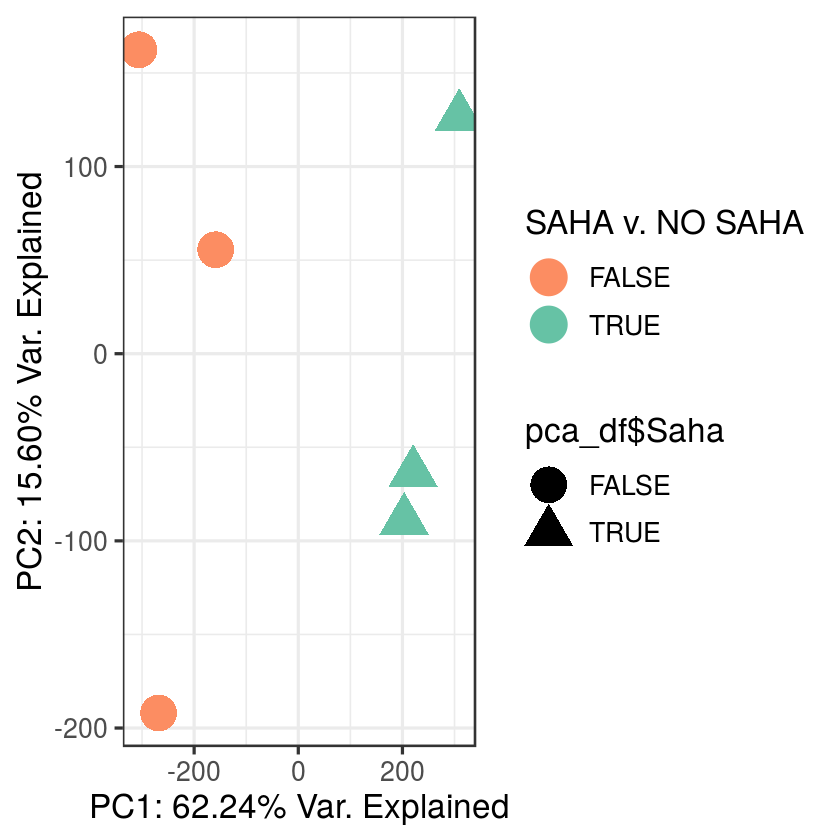

In [29]:
pca_df$Saha=c(FALSE,FALSE,FALSE,TRUE,TRUE,TRUE)
pca_df$Saha=factor(pca_df$Saha)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Saha,shape=pca_df$Saha))+
  geom_point(size=10) +
  xlab("PC1: 62.24% Var. Explained")+
  ylab("PC2: 15.60% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c("#fc8d62","#66c2a5"),name="SAHA v. NO SAHA")
p1
svg("pca.softWithSaha.vs.softNoSaha.svg",width = 5, height = 5, pointsize = 12)
print(p1)
dev.off()

## Get contributions to PC1 

In [30]:
pc1_loadings=sort(data.pca$rotation[, 1])

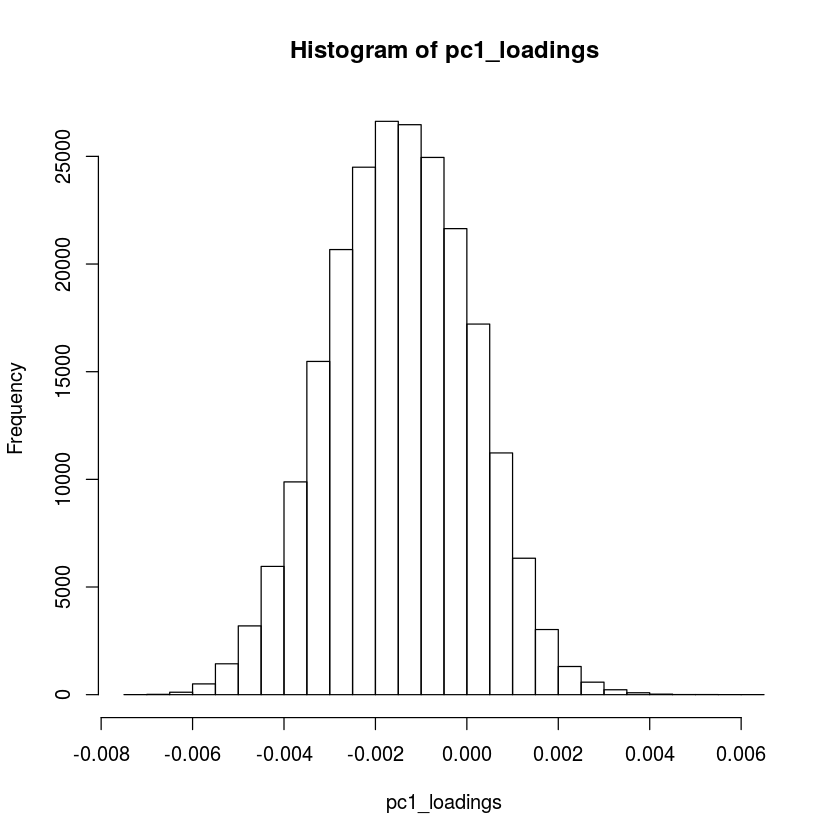

In [31]:
hist(pc1_loadings)

In [32]:
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(100)

[1] 9100
[1] 2109


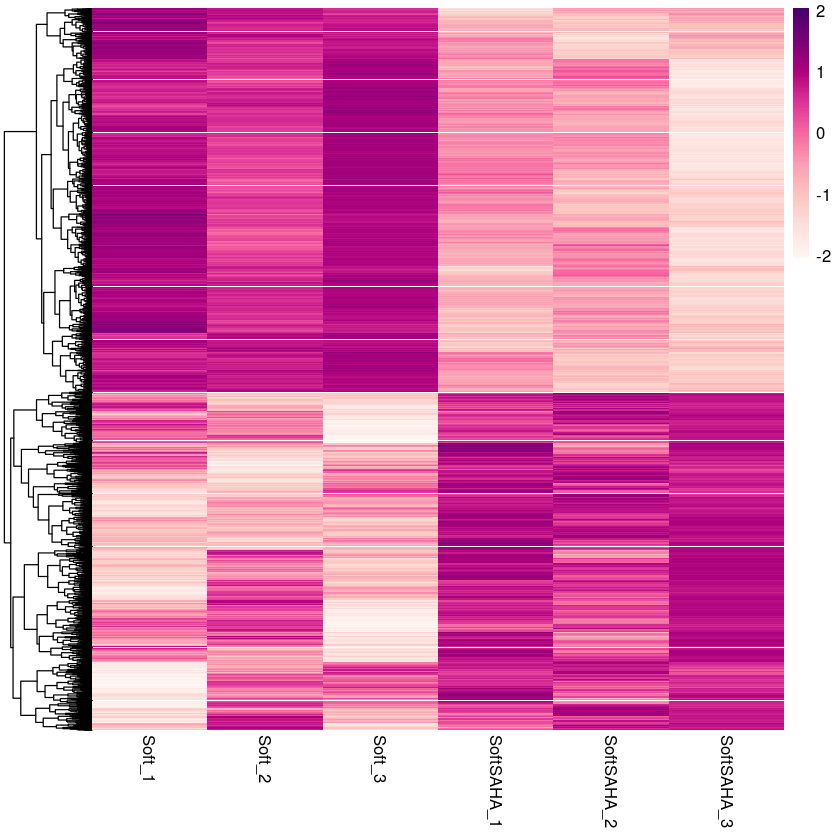

[1] 351


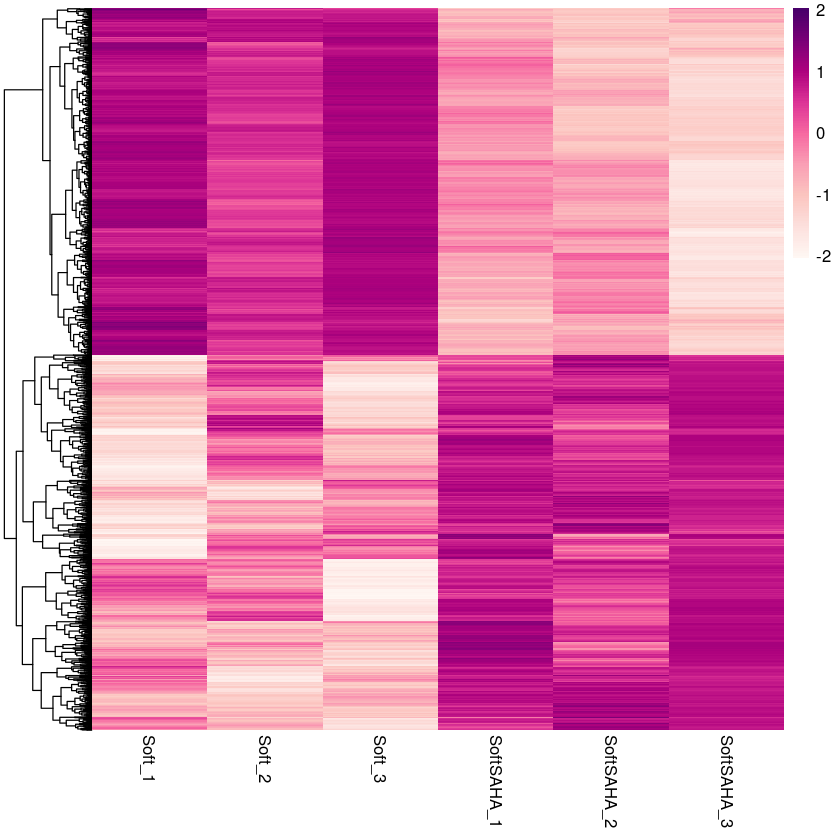

[1] 10


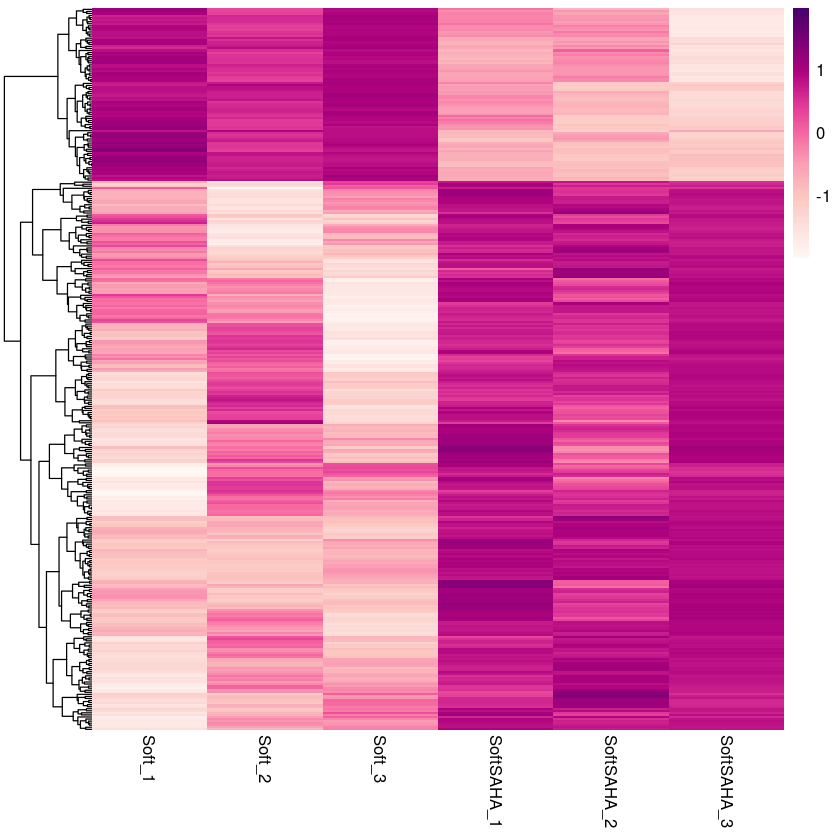

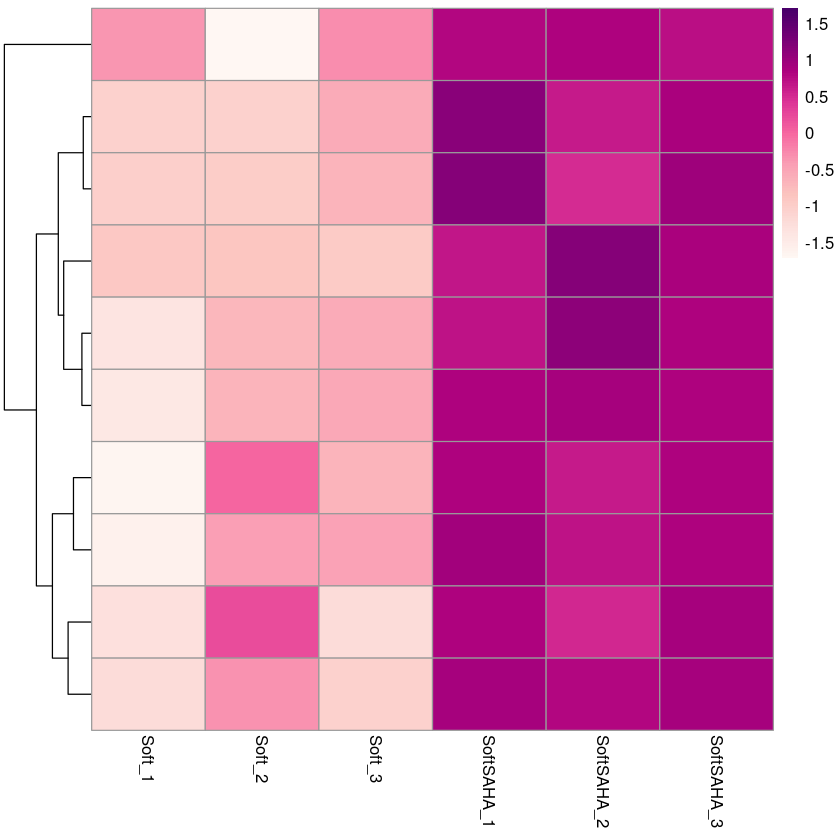

In [37]:
## Try cutoffs of 2, 2.5, 3, 4 st dev 
for(nsd in c(2,2.5,3,4))
{
    upper_bound=mean(pc1_loadings)+nsd*sd(pc1_loadings)
    lower_bound=mean(pc1_loadings)-nsd*sd(pc1_loadings)
    toselect_high=c(names(pc1_loadings[pc1_loadings>upper_bound]))
    toselect_low=c(names(pc1_loadings[pc1_loadings<lower_bound]))
    toselect=c(toselect_high,toselect_low)
    heatmap_indices=match(toselect,rownames(lognorm))
    head(heatmap_indices)
    forheatmap=lognorm[heatmap_indices,]
    outfname=paste("pc1.softNoSaha.vs.softWithSaha.",nsd,'.tsv',sep='')
    write.table(forheatmap,file=outfname,row.names=TRUE,col.names=TRUE,sep='\t')
    print(nrow(forheatmap))
    p1=pheatmap(as.matrix(forheatmap),
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=FALSE,
         labels_col=c("Soft_1","Soft_2","Soft_3","SoftSAHA_1","SoftSAHA_2","SoftSAHA_3"))
    svg(paste("softNoSaha.vs.softWithSaha.zscores.",nsd,".svg",sep=""))
    print(p1)
    dev.off() 
}

In [34]:
forheatmap

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3
chr16_22951002_22951482,0.00000000,0.000000000,0.7042992,3.067757,2.371295,2.701118
chr6_56669869_56670132,0.00000000,2.196065746,0.1127812,3.072200,2.639665,3.163284
chr9_94915809_94916085,0.00000000,0.001739193,0.4685979,3.156943,2.187899,2.876723
chr1_148241010_148242163,1.25747066,3.830306320,2.8155438,5.098301,4.775141,5.102532
chr3_42801944_42802298,0.03695737,0.078969721,0.0000000,2.360475,3.096128,2.644672
chr7_73913211_73913792,2.06819230,3.051792650,3.2360284,5.164161,5.775834,5.363210
chr5_52079191_52079507,0.14079536,2.021146473,1.9733506,4.179733,3.793437,4.056999
chr14_39903673_39903948,0.00000000,1.252027098,1.4412559,3.678765,3.776175,3.684095
chr12_10513386_10514070,2.92407356,0.000000000,3.0594453,5.417529,5.481304,5.268711
chrX_22140546_22141102,1.97785667,3.502103743,2.2759194,5.563141,5.389599,5.580127
